In [5]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

ROOT.gROOT.ProcessLine(".x ./rootlogon.C")

from ROOT import cPhysicalHit
from ROOT import cPhysicalEvent
from ROOT import MEventReduced

import time


ARDA ENVIRONMENT LOADED


In [6]:
run_f = 140
run_l = 140

In [7]:
NPADX = 128
NPADY = 128
NB_COBO = 17
NB_ASAD = 4
NB_AGET = 4
NB_CHANNEL = 68
NB_SAMPLES = 512
ONLINE_WAIT_NEWRUN = 20
MERGE_DPT = 150


class calCoeff:
    m = 0.
    q = 0.


# dummy VDrift
Vdrift = 1.0

lT = pd.read_csv(
    "/home/lorenzo/Desktop/Ganil_Actar/ACTAR_ANALYSIS_LIGHT/dat/LT.dat", sep='\t', header=None)
TABLE = np.array(lT.dropna(axis=1))

fout = ROOT.TFile("pyOutputPrecal.root", "RECREATE")
if(fout.IsZombie()):
    assert(fout.IsZombie()), "Date provided can't be in the past"


fout.cd()
outTree = ROOT.TTree("physicalEventTree", "physicalEventTree")

phEvt = cPhysicalEvent()
outTree.Branch("event", phEvt)
outTree.SetDirectory(fout)
outTree.AutoSave()

Tree = ROOT.TChain("dataTree", "dataTree")

RUN = -10

for run in range(run_f, run_l+1):

    RunFile = ROOT.TString()
    RunFile.Form(
        f"/home/lorenzo/Desktop/Ganil_Actar/ACTAR_ANALYSIS_LIGHT/root_e796/Tree_Run_0{run}_Merged.root")
    Tree.AddFile(RunFile.Data(), 0, "ACTAR_TTree")

    RUN = run

entryTotal = Tree.GetEntries()
print(f"Treating {Tree.GetEntries()} entries")

# ENTRIES = np.array([32, 38, 45, 60, 62, 63, 79, 81])

EvtRed = MEventReduced()
phHit = cPhysicalHit()

f = ROOT.TFile.Open(
    "/home/lorenzo/Desktop/Ganil_Actar/ACTAR_ANALYSIS_LIGHT/root_e796/Tree_Run_0140_Merged.root")
f.ACTAR_TTree.SetBranchAddress("data", EvtRed)

itercount = 0



Treating 38747 entries


In [8]:
ar1 = []
ar2 = []
ar3 = []
ar4 = []
ar5 = []
ar6 = []
start = time.time()
end = time.time()

for event in tqdm(f.ACTAR_TTree):
    EvtRed = event.data

    itercount += 1

    # phEvt = cPhysicalEvent()

    start = time.time()

    phEvt.getHits().clear()
    phEvt.setEventNumber(EvtRed.event)
    phEvt.setTimestamp(EvtRed.timestamp)

    ar1.append(time.time()-start)

    for it in range(len(EvtRed.CoboAsad)):

        
        start = time.time()
        co = EvtRed.CoboAsad[it].globalchannelid >> 11
        asad = (EvtRed.CoboAsad[it].globalchannelid - (co << 11)) >> 9
        ag = (EvtRed.CoboAsad[it].globalchannelid -
              (co << 11) - (asad << 9)) >> 7
        ch = EvtRed.CoboAsad[it].globalchannelid - \
            (co << 11) - (asad << 9) - (ag << 7)
        where = co * NB_ASAD * NB_AGET * NB_CHANNEL + \
            asad * NB_AGET * NB_CHANNEL + ag * NB_CHANNEL + ch

        ar2.append(time.time()-start)

        #print(f"{where}   {EvtRed.CoboAsad[it].globalchannelid}")

        if (co != 31 and co != 16):

            for hit in range(len(EvtRed.CoboAsad[it].peakheight)):

                if(TABLE[where][4] != -1 and TABLE[where][5] != -1):

                    start = time.time()
                    phHit.setGlobalChannelId(where)
                    phHit[0] = TABLE[where][4]
                    phHit[1] = TABLE[where][5]
                    phHit[2] = EvtRed.CoboAsad[it].peaktime[hit] * Vdrift
                    phHit.setEnergy(EvtRed.CoboAsad[it].peakheight[hit])
                    phHit.setTrackable(True)
                    ar3.append(time.time()-start)

            start = time.time()
            phEvt.getHits().push_back(phHit)
            ar4.append(time.time()-start)

    start = time.time()             
    outTree.Fill()
    ar5.append(time.time()-start)
    
    if itercount > 100:
        break


fout.cd()
outTree.Write()

fout.Close()

print("done")


100it [00:04, 23.06it/s]


done


IncrementalExecutor::executeFunction: symbol '_ZN14cPhysicalEvent14setEventNumberEm' unresolved while linking function '_GLOBAL__sub_I_cling_module_486'!
You are probably missing the definition of cPhysicalEvent::setEventNumber(unsigned long)
Maybe you need to load the corresponding shared library?


In [14]:
ar1 = np.array(ar1)
print(f"{ar1.mean()},   {len(ar1)}, {ar1.sum()}")
ar2 = np.array(ar2)
print(f"{ar2.mean()},   {len(ar2)}, {ar2.sum()}")
ar3 = np.array(ar3)
print(f"{ar3.mean()},   {len(ar3)}, {ar3.sum()}")
ar4 = np.array(ar4)
print(f"{ar4.mean()},   {len(ar4)}, {ar4.sum()}")
ar5 = np.array(ar5)
print(f"{ar5.mean()},   {len(ar5)}, {ar5.sum()}")

0.0018179227810094852,   101, 0.183610200881958
1.0558893287756427e-05,   111393, 1.1761868000030518
1.4528561760289335e-05,   124452, 1.8081085681915283
2.597869610077772e-06,   111292, 0.2891221046447754
0.000805847715623308,   101, 0.0813906192779541


In [5]:
forX entry in range(entryTotal):
    Tree.GetEntry(entry)

    print(f" timestamp: {len(EvtRed.CoboAsad)}")
    if(entry > 20): break

 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748
 timestamp: 748


 timestamp: 11068046444225730969


1553

In [53]:
#TABLE = np.zeros((6, NB_COBO * NB_ASAD * NB_AGET * NB_CHANNEL))
#TABLE_INV = np.zeros((128, 128, 4))

TFile: name=pyOutputPrecal.root, title=, option=CREATE


In [56]:
outTree("physicalEventTree", "physicalEventTree") 

True

In [ ]:
TTree outTree("physicalEventTree", "physicalEventTree") 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


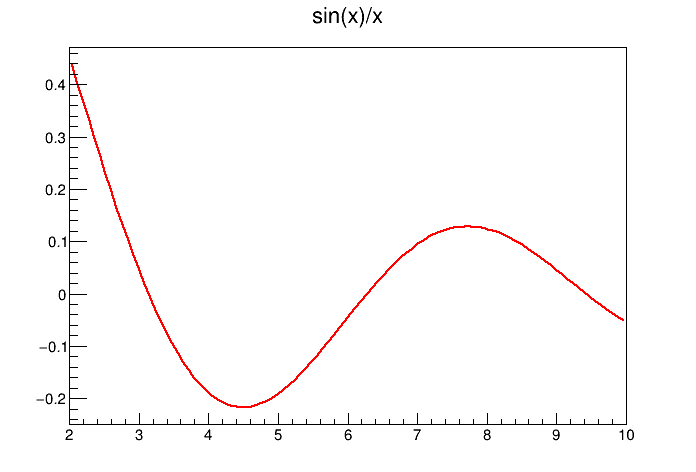

In [7]:
h = ROOT.TF1("f1", "sin(x)/x", 2, 10)
c = ROOT.TCanvas("c2", "c2")
h.Draw()
c.Draw()